## TRANSFORMER: FIRST DRAFT

### IMPORTS

In [1]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

Working in: /root/nuscenes-devkit/python-sdk/main/notebooks
Root of the project: /root/nuscenes-devkit/python-sdk


In [2]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

import torch.nn as nn

import math
import torch
from torch.nn import functional as F
import torchvision.models as models

from torch.utils.data import Dataset
from pyquaternion import Quaternion

from torch.cuda.amp import autocast, GradScaler

import numpy as np
import torch
from sklearn.cluster import KMeans
from tqdm import tqdm


MINI wayformer a partir d'embeddings

Primer s'ha hagut de fer els embeddings i concatenarlos. 

In [3]:
# shapes de entrada al Transformer (que prepararás después)
# bev_emb:      (batch_size, 1, D)
# agent_embs:   (batch_size, N_agents, D)
# lane_embs:    (batch_size, N_lanes, D)

# y luego los concatenas:
# tokens = torch.cat([bev_emb, agent_embs, lane_embs], dim=1)  # (B, T, D)


In [4]:
import gc

# 1. Función de Limpieza de Memoria (Vital para WSL)
def limpiar_memoria():
    """Fuerza al recolector de basura y vacía la VRAM"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

### agent embedding:

CADA AGENT TÉ AIXÒ: posición (x, y), velocidad, aceleración, heading (ángulo), tamaño (width, length),clase (car, pedestrian, bicycle…), historia pasada (opcional), estado actual (si está quieto o no, etc.)

amb una dimensionalidad podriem tenir un feature vector així: [x, y, vx, vy, ax, ay, heading_sin, heading_cos, width, length]


### Bird Eye View embedding

Aquest embedding hauria de ser un tensor que resumeixi tota la escena. bev_emb: (1, 1, d_model)

La imatge rasterizada en vista cenital ja està implementada a nuscnees: 

In [5]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes_mini'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.235 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


La imatge que produeix el multicanal d'unes dimensions com: (3, 224, 224)    o (3, 500, 500)  según configuración
    

Això se li pasa a una resnet (cnn) treiem un embedding i el reduim a d_model i serà el primer token del transformer

In [6]:
class BEVBackbone(nn.Module):
    def __init__(self, out_dim=128, arch="resnet18", in_channels=8, bev_grid=(8, 8)):
        super().__init__()

        self.bev_grid = bev_grid

        if arch == "resnet18":
            base = models.resnet18(weights=None)
            feat_dim = 512
        elif arch == "resnet50":
            base = models.resnet50(weights=None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")

        base.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # Remove final FC layer, keep convolutional trunk
        self.cnn = nn.Sequential(*list(base.children())[:-2])  # output

        # MLP to project onto transformer dimension
        self.proj = nn.Conv2d(feat_dim, out_dim, kernel_size=1)

        self.pool = nn.AdaptiveAvgPool2d(bev_grid)

    def forward(self, bev_img):
        """
        bev_img: (B, C, H, W)
        returns: (B, out_dim)
        """
        x = self.cnn(bev_img)         # (B, feat_dim, 1, 1)
        # x = x.view(x.size(0), -1)     # (B, feat_dim)
        x = self.proj(x)              # (B, out_dim)
        x = self.pool(x)              # (B, out_dim, H, W)
        
        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, H*W, D)
        
        return x


In [7]:
def calculate_kmeans_anchors(helper, token_list, num_modes=6):
    print("🚀 Iniciando extracción optimizada (Solo Matemáticas, sin Imágenes)...")
    
    trajectories = []
    
    # Usamos un subset seguro (ej. 3000 o todos si son pocos)
    # Si token_list es muy grande, haz un random sample, si es el de Boston filtrado, úsalo todo.
    if len(token_list) > 5000:
        indices = np.random.choice(len(token_list), 5000, replace=False)
        subset_tokens = [token_list[i] for i in indices]
    else:
        subset_tokens = token_list

    for token in tqdm(subset_tokens):
        instance_token, sample_token = token.split("_")
        
        # 1. Obtenemos el futuro DIRECTAMENTE en coordenadas del agente
        # El helper de NuScenes ya sabe hacer la matemática de rotación (in_agent_frame=True)
        future_xy = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=True)
        
        # 2. Filtrado de calidad
        # Solo queremos trayectorias completas (12 puntos) para que el KMeans sea preciso
        if future_xy.shape[0] == 12:
            trajectories.append(future_xy)
    
    # Convertir a numpy stack
    all_trajs = np.stack(trajectories) # Shape: (N, 12, 2)
    N, T, D = all_trajs.shape
    
    print(f"📊 Calculando KMeans con {num_modes} modos sobre {N} trayectorias válidas...")
    
    # Aplanar para sklearn: (N, 24)
    flat_trajs = all_trajs.reshape(N, -1)
    
    # KMeans
    kmeans = KMeans(n_clusters=num_modes, random_state=42, n_init=10)
    kmeans.fit(flat_trajs)
    
    # Recuperar forma original (M, 12, 2)
    anchors = kmeans.cluster_centers_.reshape(num_modes, T, D)
    
    # Convertir a Tensor
    anchors_tensor = torch.from_numpy(anchors).float()
    
    print("✅ ¡Anclas calculadas y optimizadas!")
    return anchors_tensor

In [8]:
def generate_dynamic_anchors(current_state, num_modes=6, horizon=12, dt=0.5):
    """
    Genera anclas basadas en la velocidad actual del agente.
    current_state: Tensor (B, 10) -> [x, y, vx, vy, ...] (Local frame)
    """
    B = current_state.shape[0]
    device = current_state.device
    
    # 1. Extraer Velocidad Local (Asumiendo vx, vy en índices 2 y 3)
    # En local frame, vx suele ser la velocidad hacia adelante.
    vx = current_state[:, 2] 
    vy = current_state[:, 3] 
    speed = torch.sqrt(vx**2 + vy**2) # Magnitud (B,)
    
    # Evitar anclas de longitud 0 para estabilidad numérica (mínimo 1 m/s)
    speed = torch.clamp(speed, min=1.0) 

    # 2. Definir "Maniobras" relativas a la velocidad
    # Creamos perfiles de curvatura y aceleración
    # Formato: (Multiplicador Velocidad, Curvatura)
    # Mode 0: Parado/Muy lento
    # Mode 1: Velocidad Constante (Recto)
    # Mode 2: Acelerar suave
    # Mode 3: Frenar suave
    # Mode 4: Giro Izquierda (V cte)
    # Mode 5: Giro Derecha (V cte)
    
    # Tiempos: (1, 12) -> [0.5, 1.0, ..., 6.0]
    t = torch.arange(1, horizon + 1, device=device).float() * dt 
    t = t.unsqueeze(0).repeat(B, 1) # (B, 12)

    anchors = torch.zeros(B, num_modes, horizon, 2, device=device)
    
    # --- Generación de Modos ---
    
    # M0: Slow/Stop (Velocidad * 0.1)
    anchors[:, 0, :, 0] = speed.unsqueeze(1) * t * 0.1
    
    # M1: Constant Velocity (Recto) -> x = v*t
    anchors[:, 1, :, 0] = speed.unsqueeze(1) * t
    
    # M2: Accelerate (1.5x)
    anchors[:, 2, :, 0] = speed.unsqueeze(1) * t * 1.5
    
    # M3: Decelerate (0.5x)
    anchors[:, 3, :, 0] = speed.unsqueeze(1) * t * 0.5
    
    # M4: Left Turn (Aprox simple: x=vt, y=0.3*x)
    dist = speed.unsqueeze(1) * t
    anchors[:, 4, :, 0] = dist
    anchors[:, 4, :, 1] = dist * 0.5 # Desvío lateral proporcional
    
    # M5: Right Turn
    anchors[:, 5, :, 0] = dist
    anchors[:, 5, :, 1] = dist * -0.5
    
    return anchors # (B, Modes, Steps, 2)

In [9]:
class PositionalEncoding(nn.Module):
    """
    Standard sine-cosine positional encoding from the "Attention is All You Need" paper.
    Adds position information to each token in the sequence.
    """

    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # shape -> (1, max_len, d_model) to broadcast over batch
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        seq_len = x.size(1)
        # Add positional encoding to the input embeddings
        x = x + self.pe[:, :seq_len, :]
        return x


class TrajectoryTransformer(nn.Module):
    """
    Transformer-based trajectory prediction model.

    Inputs:
        - token_embeddings: (batch_size, seq_len, d_model)
          Sequence of tokens from:
            * 1 BEV embedding
            * N agent embeddings
            * M lane embeddings

    Outputs:
        - trajectories: (batch_size, num_modes, num_steps, 2)
        - mode_logits (optional): (batch_size, num_modes)
    """

    def __init__(
        self,
        anchors: torch.Tensor | None = None,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_modes: int = 1,
        num_steps: int = 12,
        use_mode_head: bool = True,
        num_bev_tokens: int | None = None,
    ):
        super().__init__()

        self.d_model = d_model
        self.num_modes = num_modes
        self.num_steps = num_steps
        self.use_mode_head = use_mode_head
        self.num_bev_tokens = num_bev_tokens

        # Positional encoding for the sequence tokens
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=256)

        # Transformer encoder (no decoder needed, we just encode the scene)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # input/output shape = (batch, seq, d_model)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # Guardar anclas como buffer (no entrenable, pero parte del modelo)
        # anchors shape: (num_modes, num_steps, 2)

        #### with anchors ####
        # self.register_buffer("anchors", anchors)
        
        # self.num_modes = anchors.shape[0]
        # self.num_steps = anchors.shape[1]

        ####

        # We will use the "scene token" representation to decode trajectories.
        # Typically we take the first token (e.g. BEV or a special [CLS]-like token).
        self.scene_pool = "first"  # could be 'mean' if you want average pooling
        
        # HEAD: Ahora predice residuos, no coordenadas absolutas
        # Inicializamos con pesos pequeños para que al principio output ~= 0
        self.traj_head = nn.Sequential(
            nn.Linear(d_model, self.num_modes * self.num_steps * 2),
            nn.Tanh() # Salida entre -1 y 1
        )
        # Define una escala máxima (ej. 10 metros de corrección máxima)
        self.residual_scale = 10.0
        
        # Optional mode classification head (for multi-modal prediction)
        if use_mode_head and self.num_modes > 1:
            self.mode_head = nn.Linear(d_model, self.num_modes)
        else:
            self.mode_head = None

    def _pool_scene_token(self, encoded_tokens: torch.Tensor) -> torch.Tensor:
        """
        encoded_tokens: (batch_size, seq_len, d_model)
        Returns:
            scene_emb: (batch_size, d_model)
        """
        if self.num_bev_tokens is None:
            raise ValueError("num_bev_tokens must be set for BEV pooling")

        scene_emb = encoded_tokens[:, :self.num_bev_tokens, :].mean(dim=1)
        return scene_emb

    def forward(
        self,
        token_embeddings: torch.Tensor,
        src_key_padding_mask: torch.Tensor | None = None,
        custom_anchors: torch.Tensor | None = None,
    ):
        """
        Args:
            token_embeddings: (batch_size, seq_len, d_model)
            src_key_padding_mask: optional boolean mask of shape (batch_size, seq_len)
                True for positions that should be masked (i.e., padding tokens).

        Returns:
            trajectories: (batch, num_modes, num_steps, 2)
            mode_logits (or None): (batch, num_modes)
        """

        # 1) Add positional encoding
        x = self.pos_encoder(token_embeddings)  # (B, T, D)

        # 2) Transformer encoder
        # If using src_key_padding_mask, it must be (B, T)
        encoded = self.transformer_encoder(
            x,
            src_key_padding_mask=src_key_padding_mask,
        )  # (B, T, D)

        # 3) Pool scene representation (e.g. from first token)
        scene_emb = self._pool_scene_token(encoded)  # (B, D)

        # 1. Predecir Residuos
        residuals = self.traj_head(scene_emb) # (B, M*T*2)
        residuals = residuals.view(-1, self.num_modes, self.num_steps, 2) # (B, M, T, 2)
        
        residuals = residuals * self.residual_scale

        ### anchors ###
        # if custom_anchors is not None:
        #     # Usar las anclas que acabamos de generar
        #     base_anchors = custom_anchors
        # else:
        #     # Fallback a las viejas (por si acaso)
        #     base_anchors = self.anchors.unsqueeze(0)

        # trajectories = base_anchors + residuals
        ###
        
        # 2. Sumar Anclas (Broadcasting)
        # Anclas (1, M, T, 2) + Residuos (B, M, T, 2)
        trajectories = residuals
        
        # 3. Logits
        mode_logits = self.mode_head(scene_emb)
        
        return trajectories, mode_logits

        # # 5) Optional mode logits for multi-modal weighting
        # mode_logits = None
        # if self.mode_head is not None:
        #     mode_logits = self.mode_head(scene_emb)  # (B, num_modes)

        # return trajectories, mode_logits


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OffRoadLoss(nn.Module):
    def __init__(self, resolution=0.223, grid_size=224):
        """
        resolution: Metros por píxel (aprox 0.223 en tu config)
        grid_size: Tamaño de la imagen BEV (224)
        """
        super().__init__()
        self.resolution = resolution
        self.grid_size = grid_size
        self.half_size = grid_size / 2.0  # El centro de la imagen (112.0)

    def forward(self, trajectories, bev_map):
        """
        trajectories: (B, M, T, 2) -> Coordenadas predichas en metros (Local Frame)
        bev_map: (B, C, H, W) -> Mapa semántico. Asumimos canal 0 = Drivable Area.
        """
        B, M, T, _ = trajectories.shape
        
        # ------------------------------------------------------------
        # 1. PREPARACIÓN DEL MAPA
        # ------------------------------------------------------------
        # Seleccionamos solo el canal "Drivable Area" (Canal 0)
        # Expandimos el mapa para tener una copia por cada 'Modo' de trayectoria
        # De (B, 1, H, W) pasamos a (B*M, 1, H, W)
        drivable_mask = bev_map[:, 0:1, :, :] 
        drivable_expanded = drivable_mask.repeat_interleave(M, dim=0)

        # ------------------------------------------------------------
        # 2. TRANSFORMACIÓN DE COORDENADAS (LO QUE PREGUNTABAS)
        # ------------------------------------------------------------
        # trajectories[..., 0] es X (Adelante/Atrás en tu local frame)
        # trajectories[..., 1] es Y (Izquierda/Derecha en tu local frame)
        
        pred_x = trajectories[..., 0]
        pred_y = trajectories[..., 1]

        # PASO A: Metros -> Píxeles
        # Dividimos por la resolución para ver cuántos píxeles nos movemos.
        # Sumamos half_size (112) porque (0,0) metros es el CENTRO de la imagen.
        x_pixel = (pred_x / self.resolution) + self.half_size
        
        # PASO B: Inversión del Eje Y
        # En el mundo real, +Y es Izquierda.
        # En las imágenes, el pixel (0,0) está arriba a la izquierda y Y crece hacia ABAJO.
        # Por tanto, moverse a la Izquierda (subir en el mapa visual) es RESTAR píxeles en Y.
        y_pixel = (-pred_y / self.resolution) + self.half_size 

        # ------------------------------------------------------------
        # 3. NORMALIZACIÓN PARA GRID_SAMPLE [-1, 1]
        # ------------------------------------------------------------
        # PyTorch no entiende "pixel 112", entiende "-1 (borde izq) a 1 (borde der)".
        # Fórmula: (pixel / ancho_total) * 2 - 1
        x_norm = (x_pixel / self.grid_size) * 2.0 - 1.0
        y_norm = (y_pixel / self.grid_size) * 2.0 - 1.0

        # Apilamos para crear el "grid" que pide PyTorch
        # Shape final: (B*M, T, 1, 2)
        grid = torch.stack([x_norm, y_norm], dim=-1)
        grid = grid.view(B * M, T, 1, 2) 

        # ------------------------------------------------------------
        # 4. MUESTREO Y CÁLCULO DE LOSS
        # ------------------------------------------------------------
        # "Miramos" en el mapa qué valor hay en esas coordenadas.
        # sampled_val será aprox 1.0 si es carretera, 0.0 si es acera/pared.
        sampled_val = F.grid_sample(drivable_expanded, grid, align_corners=False, padding_mode='zeros')
        
        # sampled_val shape: (B*M, 1, T, 1) -> Quitamos dims extra -> (B, M, T)
        sampled_val = sampled_val.view(B, M, T)

        # LA LOSS:
        # Queremos que sampled_val sea 1 (estar en carretera).
        # Si sampled_val es 0 (off-road), el error es (1 - 0) = 1 (Castigo máximo).
        # Si sampled_val es 1 (on-road), el error es (1 - 1) = 0 (Sin castigo).
        loss = 1.0 - sampled_val
        
        return loss.mean()

In [11]:
class MultiModalTrajectoryLoss(nn.Module):
    """
    Multimodal loss for trajectory prediction:
      - Picks the best mode based on L2 distance (ADE)
      - Applies regression loss on that mode (Smooth L1)
      - Applies cross entropy on mode logits
    """

    def __init__(self, regression_weight=1.0, classification_weight=1.0, vel_weight=0.5, acc_weight=0.1, fde_weight=1.0, dt=0.5, offroad_weight=1.0):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.vel_weight = vel_weight
        self.acc_weight = acc_weight
        self.fde_weight = fde_weight
        self.dt = dt
        self.reg_loss_fn = nn.SmoothL1Loss()

        self.offroad_loss_fn = OffRoadLoss() 
        self.offroad_weight = offroad_weight          

    def forward(self, trajectories, mode_logits, gt_future, bev_map):
        B, M, T, _ = trajectories.shape

        # --- Errors per mode ---
        diff = trajectories - gt_future.unsqueeze(1)
        l2 = torch.norm(diff, dim=-1)  # (B, M, T)
        pos_err = l2.mean(dim=-1)      # (B, M)

        pred_v = (trajectories[:, :, 1:] - trajectories[:, :, :-1]) / self.dt
        gt_v = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
        vel_err = torch.norm(pred_v - gt_v.unsqueeze(1), dim=-1).mean(dim=-1)

        fde_err = torch.norm(
            trajectories[:, :, -1] - gt_future[:, -1].unsqueeze(1),
            dim=-1
        )

        total_mode_error = (
            pos_err
            + self.vel_weight * vel_err
            + self.fde_weight * fde_err
        )

        # --- Best mode (no grad) ---
        with torch.no_grad():
            best_mode = total_mode_error.argmin(dim=1)

        best_traj = trajectories[torch.arange(B), best_mode]

        # --- Regression loss ---
        pos_loss = self.reg_loss_fn(best_traj, gt_future)

        pred_v_best = (best_traj[:, 1:] - best_traj[:, :-1]) / self.dt
        gt_v_best = (gt_future[:, 1:] - gt_future[:, :-1]) / self.dt
        vel_loss = self.reg_loss_fn(pred_v_best, gt_v_best)

        pred_a = (pred_v_best[:, 1:] - pred_v_best[:, :-1]) / self.dt
        gt_a = (gt_v_best[:, 1:] - gt_v_best[:, :-1]) / self.dt
        acc_loss = self.reg_loss_fn(pred_a, gt_a)

        fde_loss = self.reg_loss_fn(best_traj[:, -1], gt_future[:, -1])

        reg_loss = (
            pos_loss
            + self.vel_weight * vel_loss
            + self.acc_weight * acc_loss
            + self.fde_weight * fde_loss
        )

        # --- Soft classification loss ---
        with torch.no_grad():
            mode_target = F.softmax(-total_mode_error, dim=1)

        cls_loss = F.kl_div(
            F.log_softmax(mode_logits, dim=1),
            mode_target,
            reduction="batchmean"
        )

        # --- Off-road loss ---
        offroad_loss = self.offroad_loss_fn(trajectories, bev_map)

        total_loss = self.reg_weight * reg_loss + self.cls_weight * cls_loss + self.offroad_weight * offroad_loss

        return total_loss, pos_loss.detach(), vel_loss.detach(), acc_loss.detach(), cls_loss.detach(), fde_loss.detach(), offroad_loss.detach(), best_mode

In [12]:
# ==========================================
# 1. HELPER: Extracción de datos crudos
# ==========================================
def extract_agent_features_dict(helper, instance_token, sample_token):
    """
    Extrae datos crudos en coordenadas GLOBALES y los devuelve en un dict.
    Esto permite que el Dataset los transforme a LOCALES después.
    """
    ann = helper.get_sample_annotation(instance_token, sample_token)
    
    # Velocidad Global
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0
    
    # Aceleración Global
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    # Orientación Global
    yaw = Quaternion(ann["rotation"]).yaw_pitch_roll[0]
    
    # Vectorizar velocidad/aceleración globalmente
    vx = speed * np.cos(yaw)
    vy = speed * np.sin(yaw)
    ax = accel * np.cos(yaw)
    ay = accel * np.sin(yaw)

    return {
        'pos': ann['translation'][:2],  # Global x,y
        'vel': np.array([vx, vy]),      # Global vx,vy
        'acc': np.array([ax, ay]),      # Global ax,ay
        'yaw': yaw,                     # Global yaw
        'size': ann['size'][:2],        # w, l
        'rotation': ann['rotation']     # quaternion
    }

In [ ]:
# ==========================================
# 2. DATASET: Lógica principal (Global -> Local)
# ==========================================
class NuScenesTransformerDataset(Dataset):
    def __init__(self, helper, split_name='train', max_agents=12, input_representation=None, overwrite_cache=False, cache_dir = '../configs/cache_files'):
        self.helper = helper
        self.max_agents = max_agents
        self.split_name = split_name
        
        # Guardamos el input_rep si nos lo pasan, para no crearlo dos veces
        self.input_rep = input_representation
        self.overwrite_cache = overwrite_cache
        # Nombre de caché dinámico según el split (train/val) y la ciudad
        # Así no mezclas datos si cambias de split
        os.makedirs(cache_dir, exist_ok=True)
        cache_file = os.path.join(cache_dir, f'cache_{split_name}_allcities_tokens.json')

        # -----------------------------------------------------
        # 1. INTENTAR CARGAR CACHÉ
        # -----------------------------------------------------
        if not self.overwrite_cache and os.path.exists(cache_file):
            print(f"⚡ ¡Caché global encontrado! Cargando lista desde '{cache_file}'...")
            with open(cache_file, 'r') as f:
                self.token_list = json.load(f)
            print(f"✅ Carga instantánea: {len(self.token_list)} muestras listas.")
            
            # Si no nos pasaron el input_rep, inicializarlo (si tienes ese método definido)
            if self.input_rep is None and hasattr(self, '_init_rasterizers'):
                self._init_rasterizers()
            return
        
        # -----------------------------------------------------
        # 2. GENERACIÓN DE CACHÉ (Todos los mapas + Chequeo de Disco)
        # -----------------------------------------------------
        print(f"🔄 Generando lista filtrada para '{split_name}' (Todas las ubicaciones)...")
        
        try:
            full_token_list = get_prediction_challenge_split(split_name, dataroot=helper.data.dataroot)
        except Exception as e:
            print(f"❌ Error obteniendo split: {e}")
            self.token_list = []
            return

        self.token_list = []
        valid_scenes = set()    # Escenas que SABEMOS que están en disco
        missing_scenes = set()  # Escenas que SABEMOS que faltan en disco (optimización)
        
        print(f"🌍 Procesando {len(full_token_list)} candidatos...")

        # Iteramos sobre todos los tokens posibles
        for token in full_token_list:
            instance_token, sample_token = token.split("_")

            try:
                sample = self.helper.data.get('sample', sample_token)
            except KeyError:
                continue

            scene_token = sample['scene_token']
            
            # --- AQUÍ QUITAMOS EL FILTRO DE BOSTON ---
            # Antes verificábamos si la escena era de Boston. Ahora aceptamos todas.
            
            # 1. OPTIMIZACIÓN POR ESCENA
            # Si ya validamos que esta escena existe en disco, la añadimos directo
            if scene_token in valid_scenes:
                self.token_list.append(token)
                continue
            
            # Si ya validamos que esta escena NO existe, la saltamos directo
            if scene_token in missing_scenes:
                continue
            
            # 2. FILTRO DISCO (Verificación real)
            # Comprobamos si existe la imagen de cámara para saber si tenemos los datos descargados
            cam_token = sample['data']['CAM_FRONT']
            cam_path = self.helper.data.get_sample_data_path(cam_token)
            
            if os.path.exists(cam_path):
                valid_scenes.add(scene_token)
                self.token_list.append(token)
            else:
                # Si falta la imagen, asumimos que falta toda la escena para no chequear mil veces
                missing_scenes.add(scene_token)

        # GUARDAR CACHÉ
        print(f"💾 Guardando lista GLOBAL en '{cache_file}'...")
        with open(cache_file, 'w') as f:
            json.dump(self.token_list, f)

        print(f"✅ Dataset listo. {len(self.token_list)} muestras disponibles (de todas las ciudades).")     
        
    def __len__(self):
        return len(self.token_list)

    def global_to_local(self, origin_translation, origin_rotation, points_global):
        """Transforma puntos globales a coordenadas locales del agente."""
        points_global = np.array(points_global)
        if points_global.ndim == 1:
            points_global = points_global[None, :]
            
        points_centered = points_global - origin_translation[:2]
        
        q = Quaternion(origin_rotation)
        q_inv = q.inverse
        
        points_local = []
        for p in points_centered:
            p_3d = np.array([p[0], p[1], 0.0])
            p_rot = q_inv.rotate(p_3d)
            points_local.append(p_rot[:2])
            
        return np.array(points_local, dtype=np.float32)

    def rotate_vector(self, vector, origin_rotation):
        """Rota un vector de velocidad/aceleración al frame local."""
        q = Quaternion(origin_rotation)
        q_inv = q.inverse 
        
        v_3d = np.array([vector[0], vector[1], 0.0])
        v_rot = q_inv.rotate(v_3d)
        return v_rot[:2]

    def __getitem__(self, idx):
        instance_token, sample_token = self.token_list[idx].split("_")
        
        # --- 1. BEV IMAGE ---
        img_arr = self.input_rep.make_input_representation(instance_token, sample_token)
        # (H, W, C) -> (C, H, W)
        # img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        # img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)

        img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        
        # Normalización POR CANAL (clave para semántica)
        mean = img_tensor.mean(dim=(1, 2), keepdim=True)
        std  = img_tensor.std(dim=(1, 2), keepdim=True)

        img_tensor = (img_tensor - mean) / (std + 1e-6)

        # --- 2. AGENT FEATURES ---
        anns = self.helper.get_annotations_for_sample(sample_token)
        target_ann = self.helper.get_sample_annotation(instance_token, sample_token)
        
        ego_trans = target_ann['translation']
        ego_rot = target_ann['rotation']
        ego_yaw = Quaternion(ego_rot).yaw_pitch_roll[0]

        agent_feats_list = []
        candidates = [target_ann] + [a for a in anns if a['instance_token'] != instance_token]
        candidates = candidates[:self.max_agents]

        for ann in candidates:
            # A. Extraer crudos (GLOBAL)
            raw = extract_agent_features_dict(self.helper, ann['instance_token'], sample_token)
            
            # B. Transformar (LOCAL)
            local_pos = self.global_to_local(ego_trans, ego_rot, raw['pos'])[0] 
            local_vel = self.rotate_vector(raw['vel'], ego_rot)
            local_acc = self.rotate_vector(raw['acc'], ego_rot)
            yaw_rel = raw['yaw'] - ego_yaw
            
            # C. Construir vector
            feat_vec = np.array([
                local_pos[0], local_pos[1],      # 0, 1
                local_vel[0], local_vel[1],      # 2, 3
                local_acc[0], local_acc[1],      # 4, 5
                np.sin(yaw_rel), np.cos(yaw_rel),# 6, 7
                raw['size'][0], raw['size'][1]   # 8, 9
            ], dtype=np.float32)
            
            agent_feats_list.append(feat_vec)

        # --- 3. MASK & PADDING ---
        agent_mask = torch.ones(self.max_agents, dtype=torch.bool)
        agent_mask[:len(agent_feats_list)] = False
        
        while len(agent_feats_list) < self.max_agents:
            agent_feats_list.append(np.zeros(10, dtype=np.float32))
            
        agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)

        # --- 4. GROUND TRUTH (Future) ---
        gt_global = self.helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
        gt_local = self.global_to_local(ego_trans, ego_rot, gt_global)
        
        # Padding GT
        T = 12
        if gt_local.shape[0] < T:
             pad = np.zeros((T - gt_local.shape[0], 2))
             if len(gt_local) > 0:
                 pad[:] = gt_local[-1]
             gt_local = np.concatenate([gt_local, pad], axis=0)
        
        gt_tensor = torch.tensor(gt_local, dtype=torch.float32)

        # ============================================================
        # 🔥 DATA AUGMENTATION (Random Horizontal Flip)
        # ============================================================
        # Solo aplicamos esto si estamos entrenando ('train' o 'train_mini')
        # Y con una probabilidad del 50%
        # if 'train' in self.split_name and torch.rand(1).item() < 0.5:
            
        #     # 1. Flip Imagen (Eje W es el dim 2)
        #     # La imagen BEV centrada en el ego tiene el ancho en dim 2.
        #     img_tensor = torch.flip(img_tensor, dims=[2])
            
        #     # 2. Flip Agentes (Invertir eje Y)
        #     # Índices con componente Y:
        #     # 1: pos_y, 3: vel_y, 5: acc_y
        #     # 6: sin(yaw) -> sin(-x) = -sin(x)
        #     agent_tensor[:, [1, 3, 5, 6]] *= -1
            
        #     # 3. Flip Ground Truth (Invertir eje Y)
        #     # gt_tensor es (T, 2) -> [x, y]. Invertimos índice 1.
        #     gt_tensor[:, 1] *= -1
            
        # ============================================================

        # --- CORRECCIÓN DE ROTACIÓN (La que hicimos antes) ---
        # Rotamos -90 grados para alinear Visual (Arriba) con Física (Derecha/X)
        # img_tensor = torch.rot90(img_tensor, k=1, dims=[1, 2])

        return {
            "bev": img_tensor,
            "agents": agent_tensor,
            "agent_mask": agent_mask,
            "gt": gt_tensor,
            "tokens": (instance_token, sample_token)
        }
    

In [14]:
# ==========================================
# 3. MODEL MODULES: Definición del Encoder
# ==========================================

class AgentEncoder(nn.Module):
    def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
        super().__init__()
        # --- CAMBIO AQUI ---
        # Añadimos LayerNorm justo a la entrada.
        # Esto forzará a que posiciones (50m) y velocidades (10m/s) tengan escalas comparables.
        self.input_norm = nn.LayerNorm(in_dim) 
        # -------------------

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, agent_features):
        # 1. Normalizamos primero
        x = self.input_norm(agent_features)
        # 2. Pasamos por el MLP
        return self.mlp(x)

In [15]:
class WayformerModel(torch.nn.Module):
    def __init__(self, device, anchors, d_model=128, num_modes=3):
        super().__init__()
        self.d_model = d_model
        self.device = device

        self.token_type_embed = nn.Embedding(2, d_model)  # 0: BEV, 1: Agent
        
        # --- CORRECCIÓN 1: Guardar la variable para usarla luego ---
        self.num_modes = num_modes 
        # -----------------------------------------------------------
        
        # 1. Encoders
        self.bev_backbone = BEVBackbone(out_dim=d_model, arch="resnet50", in_channels=NUM_SEM_CHANNELS) 
        self.agent_encoder = AgentEncoder(in_dim=10, out_dim=d_model)
        
        # 2. Transformer
        self.transformer = TrajectoryTransformer(
            anchors=anchors,
            d_model=d_model,
            num_modes=num_modes,
            num_steps=12,
            use_mode_head=True,
            num_bev_tokens=self.bev_backbone.bev_grid[0] * self.bev_backbone.bev_grid[1]
        )

        print("🚀 WayformerModel initialized.")
        print("num_bev_tokens:", self.transformer.num_bev_tokens)

    def forward(self, bev_img, agent_features, agent_mask=None):
        B = bev_img.size(0)

        # A. BEV Embedding
        bev_emb = self.bev_backbone(bev_img) 
        # bev_token = bev_emb.unsqueeze(1)

        bev_tokens = self.bev_backbone(bev_img)

        # bev_mask = torch.zeros((B, 1), dtype=torch.bool, device=self.device)
        bev_mask = torch.zeros(
            (B, bev_tokens.size(1)),
            dtype=torch.bool,
            device=self.device
        )

        # B. Agentes Embedding
        agent_emb = self.agent_encoder(agent_features)

        # GENERAR ANCLAS DINÁMICAS (Ahora sí funcionará self.num_modes)
        target_agent_state = agent_features[:, 0, :] 
        dynamic_anchors = generate_dynamic_anchors(target_agent_state, num_modes=self.num_modes)

        # C. Fusión de Tokens
        tokens = torch.cat([bev_tokens, agent_emb], dim=1)

        B = bev_img.size(0)
        N_bev = bev_tokens.size(1)
        N_agents = agent_emb.size(1)

        # --- Token type ids ---
        bev_type_ids = torch.zeros(
            (B, N_bev),
            dtype=torch.long,
            device=self.device
        )

        agent_type_ids = torch.ones(
            (B, N_agents),
            dtype=torch.long,
            device=self.device
        )

        type_ids = torch.cat([bev_type_ids, agent_type_ids], dim=1)

        # --- Token type embeddings ---
        type_emb = self.token_type_embed(type_ids)

        # --- Add to tokens ---
        tokens = tokens + type_emb
        
        # D. Fusión de Máscaras
        if agent_mask is None:
            agent_mask = torch.zeros((B, agent_features.size(1)), dtype=torch.bool, device=self.device)
            
        src_key_padding_mask = torch.cat([bev_mask, agent_mask], dim=1)

        # E. Transformer
        # --- CORRECCIÓN 2: ¡Pasar las anclas dinámicas al transformer! ---
        trajectories, mode_logits = self.transformer(
            tokens, 
            src_key_padding_mask=src_key_padding_mask,
            custom_anchors=dynamic_anchors  
        )
        # -----------------------------------------------------------------
        
        return trajectories, mode_logits

In [16]:
# ignore the warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# --- CONFIGURACIÓN ---
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 15
NUM_WORKERS = 4
NUM_MODES = 6

static_layers = [
    'drivable_area',
    'lane',
    'lane_divider',
    'road_divider',
    'ped_crossing',
    'stop_line',
    'walkway'
]

NUM_SEM_CHANNELS = len(static_layers)

In [17]:
from nuscenes.map_expansion.map_api import NuScenesMap
import numpy as np
from pyquaternion import Quaternion

def build_semantic_bev(
    helper,
    instance_token,
    sample_token,
    layers,
    canvas_size=(224, 224),
    meters_ahead=40,
    meters_behind=10,
    meters_left=25,
    meters_right=25,
):
    """
    Devuelve BEV semántico multicanal (H, W, C)
    """
    # --- Ego pose ---
    ann = helper.get_sample_annotation(instance_token, sample_token)
    ego_x, ego_y = ann['translation'][:2]
    ego_yaw = Quaternion(ann['rotation']).yaw_pitch_roll[0]
    yaw_deg = np.degrees(ego_yaw)

    # --- Map ---
    map_name = helper.get_map_name_from_sample_token(sample_token)
    nusc_map = NuScenesMap(dataroot=helper.data.dataroot, map_name=map_name)

    # --- Patch box ---
    patch_box = (
        ego_x,
        ego_y,
        meters_left + meters_right,
        meters_ahead + meters_behind,
    )

    bev_layers = []

    for layer in layers:
        # mask = nusc_map.get_map_mask(
        #     patch_box=patch_box,
        #     patch_angle=yaw_deg,
        #     layer_names=[layer],
        #     canvas_size=canvas_size
        # )
        # # mask shape: (H, W)
        # bev_layers.append(mask.astype(np.float32))
        
        mask = nusc_map.get_map_mask(
            patch_box=patch_box,
            patch_angle=yaw_deg,
            layer_names=[layer],
            canvas_size=canvas_size
        )

        # mask: (1, H, W) -> (H, W)
        mask = mask.squeeze(0).astype(np.float32)

        bev_layers.append(mask)

    # Stack -> (H, W, C)
    bev = np.stack(bev_layers, axis=-1)
    return bev

In [18]:
class SemanticBEVInputRepresentation:
    def __init__(self, helper, layers):
        self.helper = helper
        self.layers = layers

    def make_input_representation(self, instance_token, sample_token):
        return build_semantic_bev(
            helper=self.helper,
            instance_token=instance_token,
            sample_token=sample_token,
            layers=self.layers
        )

In [19]:
# 0. Crear Helper
helper = PredictHelper(nuscenes)

# --- 1. CONFIGURACIÓN DEL MAPA ---
# Definimos el área que queremos ver alrededor del coche autónomo
METERS_AHEAD  = 40
METERS_BEHIND = 10
METERS_LEFT   = 25
METERS_RIGHT  = 25

# Calculamos el ancho total en metros (25+25=50m)
total_width_meters = METERS_LEFT + METERS_RIGHT

# CLAVE: Calculamos la resolución exacta para que la salida sea 224 píxeles
# 50m / 224px = 0.223214... m/px
target_pixels = 224
resolution = total_width_meters / target_pixels

print(f"🎯 Configurando Rasterizers para output {target_pixels}x{target_pixels}...")
print(f"   Resolución calculada: {resolution:.4f} m/px")


# --- 2. INSTANCIAR RASTERIZERS CON LA NUEVA RESOLUCIÓN ---

# A. Mapa Estático (Carreteras, cruces)
static_rasterizer = StaticLayerRasterizer(
    helper,
    resolution=resolution,
    meters_ahead=METERS_AHEAD,
    meters_behind=METERS_BEHIND,
    meters_left=METERS_LEFT,
    meters_right=METERS_RIGHT,
    layer_names=static_layers
)

mtp_input_representation = SemanticBEVInputRepresentation(helper, static_layers)

🎯 Configurando Rasterizers para output 224x224...
   Resolución calculada: 0.2232 m/px


In [20]:
# 3. Crear Dataset PASANDO el objeto ya creado
# Así el dataset NO vuelve a crear los mapas, usa los que ya tienes en memoria.
train_dataset = NuScenesTransformerDataset(
    helper, 
    split_name='mini_train', 
    max_agents=12,
    input_representation=mtp_input_representation,
    overwrite_cache=False
)

⚡ ¡Caché global encontrado! Cargando lista desde '../configs/cache_files/cache_mini_train_allcities_tokens.json'...
✅ Carga instantánea: 742 muestras listas.


In [21]:
# val dataset
val_dataset = NuScenesTransformerDataset(
    helper, 
    split_name='mini_val', 
    max_agents=12,
    input_representation=mtp_input_representation,
    overwrite_cache=False
)

⚡ ¡Caché global encontrado! Cargando lista desde '../configs/cache_files/cache_mini_val_allcities_tokens.json'...
✅ Carga instantánea: 61 muestras listas.


In [22]:
# Limpiar memoria
limpiar_memoria()

# Crear DataLoaders con num_workers=0 (CRUCIAL)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

#### Visualization of Channel Layers in BEV Image

In [22]:
sample = train_dataset[0]
print(sample["bev"].shape)

torch.Size([8, 224, 224])


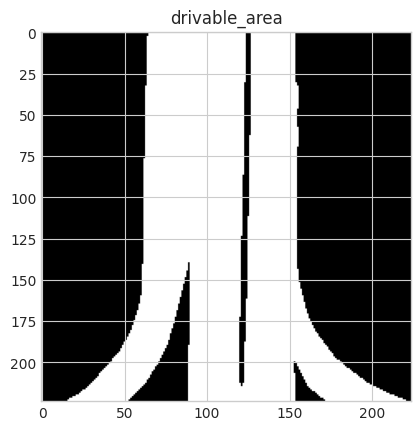

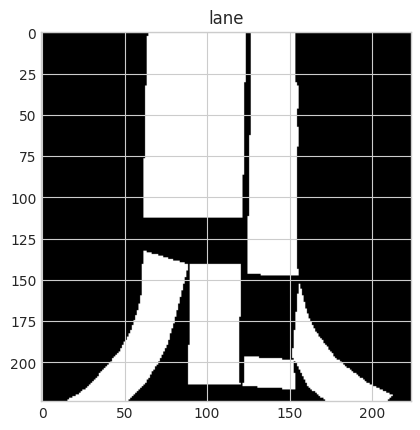

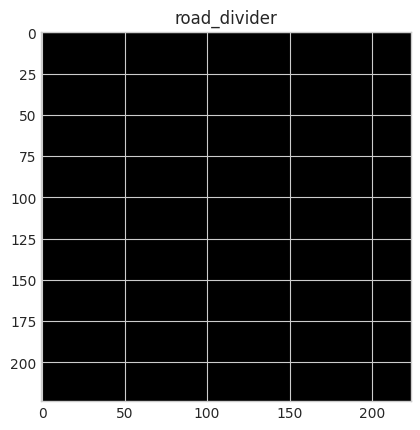

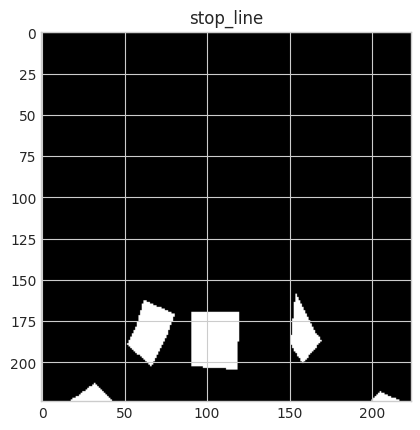

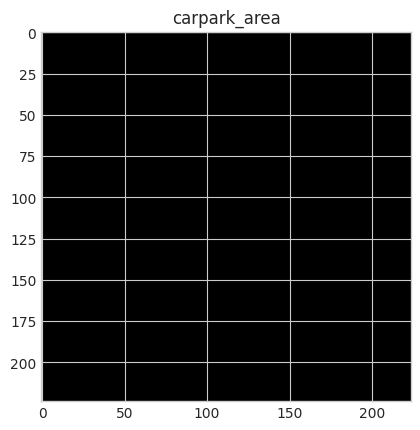

In [23]:
import matplotlib.pyplot as plt

bev = sample["bev"]

for i, name in enumerate(static_layers):
    plt.figure()
    plt.imshow(bev[i], cmap="gray")
    plt.title(name)
    plt.show()

#### Coordinates rotation and translation visualization

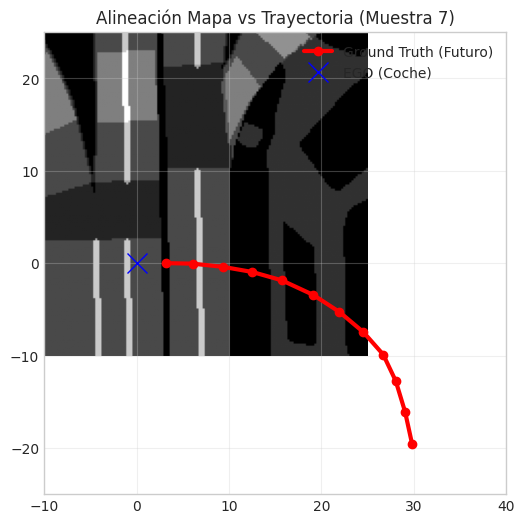

In [24]:
import matplotlib.pyplot as plt
import torch

def check_model_alignment(dataset, idx=0):
    """
    Visualiza lo que ve el modelo para confirmar que el Mapa y la Trayectoria están alineados.
    """
    # 1. Obtener datos procesados (tal cual entran a la red)
    data = dataset[idx]
    
    # Imagen BEV (C, H, W) -> (H, W, C) para plotear
    # Asumimos que data['bev'] ya tiene la rotación aplicada si hiciste el cambio
    img_tensor = data['bev']
    
    # Des-normalizar para ver algo (visualización rápida)
    img_disp = img_tensor.permute(1, 2, 0).numpy()
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
    
    # Trayectoria Ground Truth (Local Frame)
    gt = data['gt'].numpy() # (T, 2)
    
    # 2. Visualizar
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Mostrar Mapa (Capa 0 suele ser drivable area o road)
    # Mostramos la suma de canales para ver estructura
    ax.imshow(img_disp.mean(axis=2), origin='lower', extent=[-25, 25, -10, 40], cmap='gray')
    
    # Mostrar Trayectoria GT
    # OJO: extent pone el origen (0,0) según tu configuración de rasterizer
    # En tu config: meters_left=25, meters_right=25, meters_behind=10, meters_ahead=40
    # El coche (0,0) está en el centro-abajo de la imagen si no se rota.
    # Si ROTASTE la imagen, el coche debería estar a la izquierda mirando a la derecha.
    
    # Dibujamos la trayectoria tal cual viene (coordenadas locales)
    # Si todo está bien, la línea roja debería ir POR ENCIMA de la carretera blanca.
    ax.plot(gt[:, 0], gt[:, 1], color='red', linewidth=3, marker='o', label='Ground Truth (Futuro)')
    ax.plot(0, 0, 'bx', markersize=15, label='EGO (Coche)')
    
    ax.set_title(f"Alineación Mapa vs Trayectoria (Muestra {idx})")
    ax.set_xlim(-10, 40) # Zoom en la zona delantera/derecha
    ax.set_ylim(-25, 25)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.show()

# EJECUTAR PRUEBA
# Prueba con varias muestras hasta que veas una curva o movimiento claro
check_model_alignment(train_dataset, idx=7)
check_model_alignment(train_dataset, idx=2)

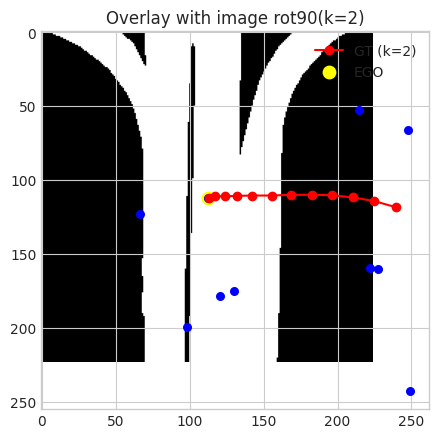

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def show_k_variants(dataset, idx, resolution):
    data = dataset[idx]
    img0 = data["bev"].clone()
    agents = data["agents"].cpu().numpy()
    gt = data["gt"].cpu().numpy()

    ks = [0, 1, -1, 2]
    for k in ks:
        img = torch.rot90(img0, k=k, dims=[1,2]).cpu().numpy()
        H, W = img.shape[1:]
        cx, cy = W//2, H//2

        plt.figure(figsize=(5,5))
        plt.imshow(img[0], cmap="gray")
        plt.plot(gt[:,0]/resolution + cx, -gt[:,1]/resolution + cy, "r-o", label=f"GT (k={k})")
        plt.scatter(cx, cy, c="yellow", s=80, label="EGO")

        # solo agentes dentro del patch (para no confundir)
        for a in agents:
            x, y = a[0], a[1]
            if abs(x) > 45 or abs(y) > 30:   # aprox rango del patch
                continue
            plt.scatter(x/resolution + cx, -y/resolution + cy, c="b", s=30)

        plt.title(f"Overlay with image rot90(k={k})")
        plt.legend()
        plt.show()

show_k_variants(train_dataset, 0, resolution)

In [28]:
def local_to_pixel(x, y, resolution,
                   meters_ahead, meters_left):
    """
    Convierte coordenadas locales (x forward, y left)
    a píxeles en el BEV de nuScenes.
    """
    # Ego position in pixels
    u0 = meters_left  / resolution
    v0 = meters_ahead / resolution

    # Proyección local -> imagen
    u = u0 - (y / resolution)
    v = v0 - (x / resolution)

    return u, v

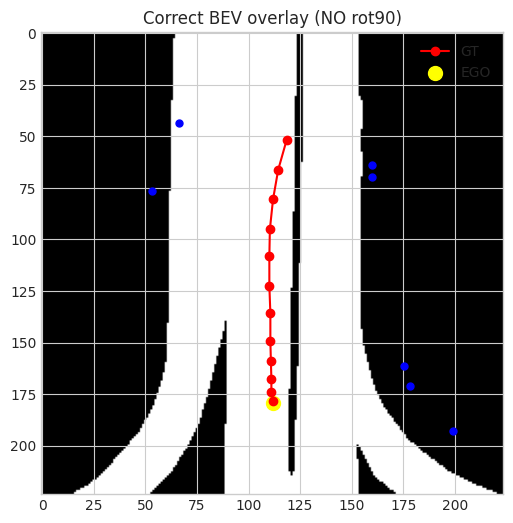

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def debug_plot_correct(sample):
    img = sample["bev"]
    agents = sample["agents"]
    gt = sample["gt"]

    plt.figure(figsize=(6,6))
    plt.imshow(img[0], cmap="gray")

    # GT
    us, vs = [], []
    for x,y in gt:
        u,v = local_to_pixel(
            x, y,
            resolution,
            METERS_AHEAD,
            METERS_LEFT
        )
        us.append(u); vs.append(v)
    plt.plot(us, vs, "r-o", label="GT")

    # Agents (solo dentro patch)
    for a in agents:
        x,y = a[0],a[1]
        if np.linalg.norm([x,y]) < 1e-3:
            continue
        if (-METERS_BEHIND <= x <= METERS_AHEAD and
            -METERS_RIGHT  <= y <= METERS_LEFT):
            u,v = local_to_pixel(
                x, y,
                resolution,
                METERS_AHEAD,
                METERS_LEFT
            )
            plt.scatter(u,v,c="b",s=25)

    # Ego
    u0 = METERS_LEFT  / resolution
    v0 = METERS_AHEAD / resolution
    plt.scatter(u0, v0, c="yellow", s=100, label="EGO")

    plt.legend()
    plt.title("Correct BEV overlay (NO rot90)")
    plt.show()

debug_plot_correct(train_dataset[0])

#### Training loop optimization

In [22]:
recalcular_anclas = False

if recalcular_anclas:
    # Calcular anclas KMeans
    anchors = calculate_kmeans_anchors(helper, train_dataset.token_list, num_modes=NUM_MODES)

    print(anchors.shape) # Debería ser (3, 12, 2)
    # Guardar en un archivo .pt (formato de Torch)
    torch.save(anchors, f'kmeans_anchors_{NUM_MODES}modes_mini.pt')
    print("💾 Anclas guardadas en disco.")

In [23]:
# anchors = torch.load(f'/root/nuscenes-devkit/python-sdk/main/configs/cache_files/kmeans_anchors_{NUM_MODES}modes_mini.pt')

def train_one_epoch(epoch_index, loader):
    model.train()

    print(f"\n--- Epoch {epoch_index+1}/{EPOCHS} ---")
    
    # Diccionario para acumular métricas
    metrics = {'total': 0, 'reg': 0, 'cls': 0, 'vel': 0, 'fde': 0, 'offroad': 0}
    num_batches = len(loader)
    
    # Barra de progreso (tqdm)
    # desc: Texto a la izquierda | postfix: Texto a la derecha (métricas en vivo)
    pbar = tqdm(enumerate(loader), total=num_batches, desc=f"Epoch {epoch_index+1}/{EPOCHS}")
    
    for i, batch in pbar:
        # A. Mover datos a GPU
        # non_blocking=True ayuda a acelerar la transferencia si pin_memory=True
        bev_img = batch['bev'].to(DEVICE, non_blocking=True)
        agent_feats = batch['agents'].to(DEVICE, non_blocking=True)
        agent_mask = batch['agent_mask'].to(DEVICE, non_blocking=True)
        gt_future = batch['gt'].to(DEVICE, non_blocking=True)
        
        # B. Forward (Estándar FP32 - Sin Autocast)
        optimizer.zero_grad(set_to_none=True) # set_to_none ahorra un poco más de RAM
        
        preds, mode_logits = model(bev_img, agent_feats, agent_mask=agent_mask)
        
        # C. Loss Calculation
        loss, reg_loss, vel_loss, acc_loss, cls_loss, fde_loss, offroad_loss, _ = criterion(preds, mode_logits, gt_future, bev_img)
        
        # D. Backward (Estándar)
        loss.backward()
        
        # E. Gradient Clipping (Obligatorio para Transformers para evitar NaN)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # F. Optimizer Step
        optimizer.step()
        
        # G. Actualizar Métricas (Usando .item() para no guardar grafos en memoria)
        loss_val = loss.item()
        reg_val = reg_loss.item()
        cls_val = cls_loss.item()
        offroad_val = offroad_loss.item()
        
        metrics['total'] += loss_val
        metrics['reg'] += reg_val
        metrics['cls'] += cls_val
        metrics['vel'] += vel_loss.item()
        metrics['fde'] += fde_loss.item()
        metrics['offroad'] += offroad_val
        
        # Actualizar la barra de progreso con los datos actuales
        pbar.set_postfix({
            'L': f"{loss_val:.3f}", 
            'Reg': f"{reg_val:.3f}", 
            'Cls': f"{cls_val:.3f}",
            'Offroad': f"{offroad_val:.3f}"
        })
        
        # H. Limpieza agresiva intra-batch (Para evitar que WSL mate el proceso)
        # Borramos las variables de GPU inmediatamente
        del bev_img, agent_feats, agent_mask, gt_future, preds, mode_logits, loss
    
    # Calcular promedios
    avg_metrics = {k: v / num_batches for k, v in metrics.items()}
    return avg_metrics

In [24]:
# 2. Instanciar Modelo y Loss
# Nos aseguramos de que esté en la GPU
model = WayformerModel(device=DEVICE, anchors=None, d_model=128, num_modes=NUM_MODES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

criterion = MultiModalTrajectoryLoss(
    regression_weight=2.0,      # Bajar de 3.0 a 1.0 (Mantener escala global controlada)
    classification_weight=1.0,  # BAJAR DRASTICAMENTE de 10.0 a 1.0 (Evita overconfidence)
    vel_weight=1.0,             # Velocidad es auxiliar, 0.5 está bien
    acc_weight=0.0,             # Aceleración es muy ruidosa, mejor 0.0 o muy bajo (0.01)
    fde_weight=1.0,             # FDE es importante, pero 2.0 es suficiente relativo al ADE
    dt=0.5,
    offroad_weight=0.0         # Pequeña penalización por off-road
)

🚀 WayformerModel initialized.
num_bev_tokens: 64


In [25]:
# 4. Loop Principal
print(f"🚀 Iniciando entrenamiento en {DEVICE} (FP32 Stable Mode)...")
print("-" * 60)

# Sincronización inicial
if torch.cuda.is_available():
    torch.cuda.synchronize()

try:
    for epoch in range(EPOCHS):
        # Llamamos a la función
        avg_metrics = train_one_epoch(epoch, train_loader)
        
        # Print resumen bonito al final de la época
        print(f"✅ Fin Epoch {epoch+1} | "
              f"Loss Total: {avg_metrics['total']:.4f} | "
              f"Reg: {avg_metrics['reg']:.4f} | "
              f"Cls: {avg_metrics['cls']:.4f} | "
              f"FDE: {avg_metrics['fde']:.4f}")
        print("-" * 60)
        
        # Limpieza profunda entre épocas
        limpiar_memoria()

except KeyboardInterrupt:
    print("\n🛑 Entrenamiento detenido manualmente.")
    limpiar_memoria()
except Exception as e:
    print(f"\n❌ Error crítico durante el entrenamiento: {e}")
    # Opcional: imprimir traceback completo
    import traceback
    traceback.print_exc()

🚀 Iniciando entrenamiento en cuda (FP32 Stable Mode)...
------------------------------------------------------------

--- Epoch 1/15 ---


Epoch 1/15: 100%|██████████| 24/24 [00:55<00:00,  2.30s/it, L=65.209, Reg=10.220, Cls=0.816, Offroad=0.237]


✅ Fin Epoch 1 | Loss Total: 79.5275 | Reg: 12.3290 | Cls: 0.9744 | FDE: 21.0810
------------------------------------------------------------

--- Epoch 2/15 ---


Epoch 2/15: 100%|██████████| 24/24 [00:59<00:00,  2.47s/it, L=86.622, Reg=13.032, Cls=0.297, Offroad=0.538]


✅ Fin Epoch 2 | Loss Total: 70.1803 | Reg: 10.3677 | Cls: 0.4904 | FDE: 20.8749
------------------------------------------------------------

--- Epoch 3/15 ---


Epoch 3/15: 100%|██████████| 24/24 [00:57<00:00,  2.38s/it, L=39.558, Reg=6.042, Cls=0.177, Offroad=0.485] 


✅ Fin Epoch 3 | Loss Total: 67.2332 | Reg: 9.8769 | Cls: 0.2252 | FDE: 20.1991
------------------------------------------------------------

--- Epoch 4/15 ---


Epoch 4/15: 100%|██████████| 24/24 [00:57<00:00,  2.39s/it, L=91.741, Reg=13.584, Cls=0.141, Offroad=0.594]


✅ Fin Epoch 4 | Loss Total: 68.2378 | Reg: 10.0038 | Cls: 0.1588 | FDE: 20.6014
------------------------------------------------------------

--- Epoch 5/15 ---


Epoch 5/15:  67%|██████▋   | 16/24 [00:46<00:23,  2.92s/it, L=64.815, Reg=9.296, Cls=0.124, Offroad=0.426] 



🛑 Entrenamiento detenido manualmente.


## Guardar modelos

In [27]:
name = f"model_8_transformer_{EPOCHS}_epochs.pth"
path_to_save = "/root/nuscenes-devkit/python-sdk/main/configs/trained_models/" + name

In [28]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), path_to_save)

## Evaluar modelos

In [ ]:
# load the model later with:
model = WayformerModel(device=DEVICE, anchors=anchors, d_model=128, num_modes=NUM_MODES).to(DEVICE)
model.load_state_dict(torch.load(path_to_save))
print(f"💾 Modelo cargado en '{path_to_save}'")

💾 Modelo cargado en '/root/nuscenes-devkit/python-sdk/main/configs/trained_models/model_6_transformer_5_epochs.pth'


In [29]:
# eval model on val set
model.eval()
with torch.no_grad():
    val_metrics = {'total': 0, 'reg': 0, 'cls': 0, 'vel': 0, 'fde': 0}
    num_batches = len(val_loader)
    
    pbar = tqdm(enumerate(val_loader), total=num_batches, desc="Evaluando en Val")
    
    for i, batch in pbar:
        bev_img = batch['bev'].to(DEVICE, non_blocking=True)
        agent_feats = batch['agents'].to(DEVICE, non_blocking=True)
        agent_mask = batch['agent_mask'].to(DEVICE, non_blocking=True)
        gt_future = batch['gt'].to(DEVICE, non_blocking=True)
        
        preds, mode_logits = model(bev_img, agent_feats, agent_mask=agent_mask)
        
        loss, reg_loss, vel_loss, acc_loss, cls_loss, fde_loss, offroad_loss, _ = criterion(preds, mode_logits, gt_future, bev_img)
        
        val_metrics['total'] += loss.item()
        val_metrics['reg'] += reg_loss.item()
        val_metrics['cls'] += cls_loss.item()
        val_metrics['vel'] += vel_loss.item()
        val_metrics['fde'] += fde_loss.item()
        
    avg_val_metrics = {k: v / num_batches for k, v in val_metrics.items()}
    print(f"✅ Evaluación Completa | "
          f"Loss Total: {avg_val_metrics['total']:.4f} | "
          f"Reg: {avg_val_metrics['reg']:.4f} | "
          f"Cls: {avg_val_metrics['cls']:.4f} | "
          f"FDE: {avg_val_metrics['fde']:.4f}")

Evaluando en Val: 100%|██████████| 2/2 [00:10<00:00,  5.02s/it]

✅ Evaluación Completa | Loss Total: 11.3595 | Reg: 3.4802 | Cls: 0.0546 | FDE: 6.3249


In [30]:
import numpy as np
import torch
import json
from tqdm import tqdm
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.eval.prediction.config import load_prediction_config

def generate_submission_notebook(model, dataset, output_path="submission_transformer.json"):
    model.eval()
    predictions_list = []
    
    helper = dataset.helper 
    print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
    # IMPORTANTE: Iterar sobre el DataLoader o Dataset correctamente
    # Usaremos el DataLoader para consistencia (aunque batch=1 para simplificar lógica aquí)
    # Nota: Tu dataset devuelve un dict {'bev', 'agents', 'tokens', 'gt'}
    
    # Ajusta esto si usas un DataLoader, aquí iteramos índice a índice para ser explícitos
    for i in tqdm(range(len(dataset))):
        
        # 1. Obtener datos (El dataset ya devuelve tensores)
        data = dataset[i]
        
        # Necesitamos batch dimension (unsqueeze)
        bev_img = data['bev'].unsqueeze(0).to(model.device)       # (1, 3, H, W)
        agent_feats = data['agents'].unsqueeze(0).to(model.device)# (1, N, 10)
        
        # Recuperar tokens (instance, sample)
        # Nota: Dataset.__getitem__ devuelve tuple en 'tokens'
        instance_token, sample_token = data['tokens']

        # 2. Inferencia
        with torch.no_grad():
            # El modelo devuelve: (trajectories, mode_logits)
            preds, mode_logits = model(bev_img, agent_feats)
        
        # 3. Procesar Salidas
        # preds: (1, Num_modos, 12, 2) -> (Num_modos, 12, 2)
        pred_coords_local = preds[0].cpu().numpy()
        
        # mode_logits: (1, Num_modos) -> (Num_modos,)
        mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        num_modes = pred_coords_local.shape[0]

        # ============================================================
        # 🌍 TRANSFORMACIÓN CRÍTICA: LOCAL -> GLOBAL
        # ============================================================
        
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation'] # [x, y, z] global
        rotation = sample_annotation['rotation']       # Quaternion global
        
        quaternion = Quaternion(rotation)
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            trajectory_local = pred_coords_local[mode_idx] # (12, 2)
            
            # A. Añadir Z=0
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
            # B. Rotar (Local -> Global rotation)
            # rotate funciona vector a vector
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
            # C. Trasladar
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

        # ============================================================

        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global,
            probabilities=mode_probs
        )

        predictions_list.append(prediction_obj.serialize())

    # Guardar JSON
    with open(output_path, "w") as f:
        json.dump(predictions_list, f, indent=2)

    return output_path

#### Validation Loss Calculation on Train Dataset

In [ ]:
# 1. Crear el dataset de validación CORRECTO
# Usamos 'mini_val' para validar rápido o 'val' si tienes el dataset completo
name = f"model_5_transformer_{EPOCHS}_epochs_submission_train.json" 
root_path = "/root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/"

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, train_dataset, root_path + name)
print(f"✅ Archivo generado: {submission_path}")

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results_train_eval = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results_train_eval.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🚗 Generando submission con conversión LOCAL -> GLOBAL...


  1%|          | 19/3360 [00:03<10:54,  5.10it/s]


KeyboardInterrupt: 

#### Val Validation Loss Calculation on Val Dataset

In [31]:
name = f"model_8_transformer_{EPOCHS}_epochs_submission_val.json"
root_path = "/root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/"

# 2. Generar submission
# La función generate_submission_notebook ya estaba bien definida en mi respuesta anterior
submission_path = generate_submission_notebook(model, val_dataset, root_path + name)

print(f"✅ Archivo generado: {submission_path}")

🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:19<00:00,  3.16it/s]

✅ Archivo generado: /root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/model_8_transformer_15_epochs_submission_val.json


In [32]:
#### METRICAS PER INTENT DE PASSAR LES DADES CRUES DELS AGENTS QUE ENVOLTEN EL AGENT A PREDIR DE DADES GLOBALS A LOCALS I AFEGIR EL TOKEN BEV ####
submission_path = "/root/nuscenes-devkit/python-sdk/main/results/prediction_challenge/" + f"/{name}"

# 3. Evaluar métricas
config = load_prediction_config(helper, "predict_2020_icra.json")
results = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [11.10524505591424, 9.593085313497884, 9.47137288919089]

--- MinADEK ---
  RowMean: [6.686423425087342, 6.185557074503342, 6.185557074503342]

--- MissRateTopK_2 ---
  RowMean: [0.9836065573770492, 0.9836065573770492, 0.9836065573770492]

--- OffRoadRate ---
  RowMean: [0.8060109289617486]


### Inspection of Multi-Modal Predictions

In [33]:
import torch
import numpy as np

def inspect_model_predictions(model, dataset, num_samples_to_inspect=5):
    """
    Imprime un desglose detallado de cada modo predicho vs Ground Truth.
    """
    device = next(model.parameters()).device
    model.eval()
    
    print(f"🔬 Inspeccionando {num_samples_to_inspect} ejemplos del dataset...\n")
    print(f"{'='*80}")
    
    for i in range(num_samples_to_inspect):
        # 1. Cargar datos
        # random index
        idx = np.random.randint(0, len(dataset))
        data = dataset[idx]
        
        # Preparar batch de tamaño 1
        bev = data['bev'].unsqueeze(0).to(device)
        agents = data['agents'].unsqueeze(0).to(device)
        agent_mask = data['agent_mask'].unsqueeze(0).to(device)
        gt_local = data['gt'].to(device) # (T, 2)
        
        # 2. Inferencia
        with torch.no_grad():
            preds, mode_logits = model(bev, agents, agent_mask=agent_mask)
            
        # preds shape: (1, Num_Modes, 12, 2)
        # mode_logits shape: (1, Num_Modes)
        
        # 3. Procesar probabilidades
        if mode_logits is not None:
            probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        else:
            n_modes = preds.shape[1]
            probs = np.ones(n_modes) / n_modes
            
        preds_local = preds[0].cpu().numpy() # (Num_Modes, 12, 2)
        gt_np = gt_local.cpu().numpy()       # (12, 2)
        
        # 4. Calcular métricas por modo MANUALMENTE
        print(f"🚗 Muestra {i} | Token: {data['tokens'][1]}")
        print(f"   Ground Truth Final (Local): ({gt_np[-1,0]:.2f}, {gt_np[-1,1]:.2f})")
        print("-" * 60)
        print(f"   {'Modo':<5} | {'Prob':<8} | {'ADE':<8} | {'FDE':<8} | {'Destino Predicho (Local)'}")
        print("-" * 60)
        
        best_ade = float('inf')
        best_mode_idx = -1
        
        for m in range(preds_local.shape[0]):
            traj = preds_local[m] # (12, 2)
            
            # Calcular error (L2 norm)
            diff = traj - gt_np
            dist_sq = diff[:,0]**2 + diff[:,1]**2
            dist = np.sqrt(dist_sq)
            
            ade = np.mean(dist)
            fde = dist[-1] # Último punto
            
            # Marker para el modo elegido por el modelo (mayor prob)
            is_chosen = (m == np.argmax(probs))
            chosen_mark = "*" if is_chosen else " "
            
            print(f"   {m} {chosen_mark}   | {probs[m]:.4f}   | {ade:.4f}   | {fde:.4f}   | ({traj[-1,0]:.2f}, {traj[-1,1]:.2f})")
            
            if ade < best_ade:
                best_ade = ade
                best_mode_idx = m
                
        print("-" * 60)
        
        # Análisis rápido
        chosen_idx = np.argmax(probs)
        if chosen_idx == best_mode_idx:
            print("   ✅ El modelo eligió el mejor modo disponible.")
        else:
            print(f"   ❌ El modelo eligió el modo {chosen_idx}, pero el mejor era el {best_mode_idx}.")
            print(f"      Desperdicio de precisión: {abs(best_ade - np.mean(np.linalg.norm(preds_local[chosen_idx] - gt_np, axis=1))):.2f}m en ADE")
            
        print(f"{'='*80}\n")

    # --- AÑADIR ESTO AL FINAL DEL BUCLE FOR ---
    print(f" 📊 Matriz Individual:")
    print(f"    Real (Best Geometric): {best_mode_idx} ({['Stop', 'Const', 'Accel', 'Decel', 'Left', 'Right'][best_mode_idx]})")
    print(f"    Pred (Max Prob):       {chosen_idx} ({['Stop', 'Const', 'Accel', 'Decel', 'Left', 'Right'][chosen_idx]})")
    
    if chosen_idx == 2 and best_mode_idx != 2:
            print("    ⚠️ ALERTA: Falso Positivo de Aceleración detectado.")
            
    print(f"{'='*80}\n")

# --- EJECUTAR ---
# Asegúrate de usar el 'val_dataset' o 'train_dataset' según quieras mirar
inspect_model_predictions(model, val_dataset, num_samples_to_inspect=5)

🔬 Inspeccionando 5 ejemplos del dataset...

🚗 Muestra 0 | Token: 700c1a25559b4433be532de3475e58a9
   Ground Truth Final (Local): (27.97, -1.66)
------------------------------------------------------------
   Modo  | Prob     | ADE      | FDE      | Destino Predicho (Local)
------------------------------------------------------------
   0     | 0.0068   | 19.4055   | 29.9301   | (-0.97, -9.30)
   1 *   | 0.9663   | 10.1914   | 18.0196   | (9.98, -0.66)
   2     | 0.0066   | 20.5768   | 27.1312   | (0.97, 0.98)
   3     | 0.0067   | 20.1110   | 26.8810   | (1.09, -1.30)
   4     | 0.0065   | 20.6396   | 24.8640   | (3.13, -0.60)
   5     | 0.0072   | 19.7401   | 26.8287   | (2.13, 5.55)
------------------------------------------------------------
   ✅ El modelo eligió el mejor modo disponible.

🚗 Muestra 1 | Token: 0d0700a2284e477db876c3ee1d864668
   Ground Truth Final (Local): (3.57, -1.45)
------------------------------------------------------------
   Modo  | Prob     | ADE      | FDE

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import numpy as np
from tqdm import tqdm

def plot_mode_confusion_matrix(model, dataloader, device, class_names=None):
    """
    Genera y visualiza la matriz de confusión de los modos de trayectoria.
    
    - True Label: El modo que geométricamente estuvo más cerca del Ground Truth (minADE).
    - Predicted Label: El modo al que el modelo dio mayor probabilidad.
    """
    model.eval()
    
    y_true = [] # El mejor modo (Geométrico)
    y_pred = [] # El modo elegido (Probabilístico)
    
    print("📊 Recopilando estadísticas para la Matriz de Confusión...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # 1. Mover a GPU
            bev = batch['bev'].to(device)
            agents = batch['agents'].to(device)
            agent_mask = batch['agent_mask'].to(device)
            gt_future = batch['gt'].to(device) # (B, T, 2)
            
            # 2. Inferencia
            trajectories, mode_logits = model(bev, agents, agent_mask)
            
            # 3. Calcular cuál fue el MEJOR modo real (Ground Truth geométrico)
            # trajectories: (B, M, T, 2)
            # gt_future: (B, T, 2) -> unsqueeze -> (B, 1, T, 2)
            diff = trajectories - gt_future.unsqueeze(1)
            l2 = torch.norm(diff, dim=-1) # (B, M, T)
            ade_per_mode = l2.mean(dim=-1) # (B, M)
            
            # El índice del modo con menor error es la "Clase Real"
            best_modes = ade_per_mode.argmin(dim=1).cpu().numpy()
            
            # 4. Calcular cuál fue el modo ELEGIDO por el modelo
            # El índice con mayor logit es la "Clase Predicha"
            pred_modes = mode_logits.argmax(dim=1).cpu().numpy()
            
            y_true.extend(best_modes)
            y_pred.extend(pred_modes)

    # --- PLOT ---
    if class_names is None:
        # Nombres por defecto según tus anclas dinámicas
        class_names = ['Stop', 'Const', 'Accel', 'Decel', 'Left', 'Right']
        # Asegurarse de que coincida con num_modes
        num_modes_found = max(max(y_true), max(y_pred)) + 1
        class_names = class_names[:num_modes_found]

    cm = confusion_matrix(y_true, y_pred)
    
    # Normalizar (opcional: para ver porcentajes en vez de cantidades absolutas)
    # cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.xlabel('Modo Predicho (Max Probabilidad)')
    plt.ylabel('Modo Real (Mejor Ajuste Geométrico)')
    plt.title('Confusion Matrix: Selección de Modos de Trayectoria')
    plt.show()

# --- CÓMO USARLO ---
# Ejecútalo pasando tu 'val_loader' para tener suficientes datos
plot_mode_confusion_matrix(model, val_loader, DEVICE)

ModuleNotFoundError: No module named 'seaborn'

### Mini val Visualization of Predictions

In [35]:
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Visualiza una predicción sobre el mapa real cargando la API de mapas correcta.
    """
    # 1. Detectar la localización (Boston/Singapore)
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    log = nusc.get('log', log_token)
    location = log['location']
    
    # 2. Instanciar el mapa de esa ciudad
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 3. Renderizar el Mapa
    # Definir el área alrededor del agente
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x, y = ann['translation'][:2]
    my_patch = (x - 40, y - 40, x + 40, y + 40) # (x_min, y_min, x_max, y_max)
    
    # --- CORRECCIÓN CLAVE ---
    # No creamos 'fig, ax = plt.subplots()' antes.
    # Llamamos a render_map_patch directamente y dejamos que cree la figura.
    # NO pasamos el argumento 'ax'.
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=static_layers,
        alpha=0.3,
        figsize=(10, 10)
    )
    
    # Recuperamos el eje actual (creado por nusc_map) para dibujar encima
    ax = plt.gca()

    # 4. Dibujar Agente (Ego)
    ax.scatter(x, y, c='black', s=200, marker='^', label='Ego Agent', zorder=5)

    # 5. Dibujar Ground Truth (Verde)
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    if len(future) > 0:
        ax.plot(future[:, 0], future[:, 1], 'g-', linewidth=4, label='Ground Truth')
        ax.scatter(future[-1, 0], future[-1, 1], c='g', s=100)

    # 6. Buscar datos en el dataset para inferencia
    target_token_str = f"{instance_token}_{sample_token}"
    idx = -1
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print(f"⚠️ Sample {target_token_str} no encontrado en el dataset.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    # 7. Inferencia
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    # Procesar Salidas
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar Local -> Global
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            # point es (x, y) local. Añadimos z=0 para rotar
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        
        traj_global = np.array(traj_global)
        
        # Estilo según probabilidad
        is_best = (i == probs.argmax())
        color = 'b' if is_best else 'r'
        alpha = 1.0 if is_best else 0.3
        linewidth = 3 if is_best else 1
        label = f'Pred ({probs[i]:.2f})' if is_best else None
        
        ax.plot(traj_global[:, 0], traj_global[:, 1], color=color, alpha=alpha, 
                linewidth=linewidth, linestyle='--', label=label)

    ax.legend()
    ax.set_title(f"Predicción Wayformer\n{location}")
    # render_map_patch ya ajusta los límites, pero aseguramos si hace falta
    # ax.set_xlim(x-40, x+40)
    # ax.set_ylim(y-40, y+40)
    plt.show()

In [38]:
# Elige un índice del dataset de validación
idx_to_plot = 50 # Puedes probar con varios índices 
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Llama a la función
visualize_sample(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

#### Visualitzar prediccions amb diferents trajectories

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion
import os

def generate_separate_mode_gifs(nusc, helper, dataset, sample_token, instance_token, model, device, output_dir="/root/nuscenes-devkit/python-sdk/main/results/gifs_output"):
    # Crear directorio de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for mode_traj in preds_local:
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))
    
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)

    print(f"Generando GIFs para {len(all_preds_global)} modos en '{output_dir}/'...")

    # ==============================================================================
    # 4. BUCLE: GENERAR UN GIF POR CADA MODO
    # ==============================================================================
    for mode_idx, mode_traj in enumerate(all_preds_global):
        
        probabilidad = probs[mode_idx]
        es_mejor_modo = (mode_idx == probs.argmax())
        color_modo = 'blue' if es_mejor_modo else 'red'
        
        # --- A. Renderizar Mapa Base ---
        # Llamamos a la función SIN pasar 'ax'. Ella creará su propia figura internamente.
        # Capturamos el resultado en una variable 'dummy' por si acaso, pero no la usaremos.
        _ = nusc_map.render_map_patch(
            box_coords=my_patch, 
            layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
            alpha=0.3,
            figsize=(8, 8)
        )
        
        # --- SOLUCIÓN CLAVE ---
        # Obtenemos la Figura y el Eje actuales que render_map_patch acaba de crear.
        # Esto evita el error de la tupla y el error del argumento 'ax'.
        fig = plt.gcf()
        ax = plt.gca()
        
        # Ahora trabajamos sobre 'ax' con seguridad
        title_text = f"Predicción MODO {mode_idx}\nProbabilidad: {probabilidad:.2%}"
        if es_mejor_modo: title_text += " [BEST]"
        ax.set_title(title_text)

        # --- B. Inicializar Objetos Gráficos ---
        ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', zorder=5)
        gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
        line, = ax.plot([], [], color=color_modo, linewidth=2, linestyle='--', label='Predicción')
        head, = ax.plot([], [], marker='o', color=color_modo, markersize=6)

        ax.legend(loc='upper right')

        # --- C. Función de Actualización ---
        def update(frame):
            artists = []
            
            # Actualizar GT
            if len(future) > frame:
                gt_point.set_data([future[frame, 0]], [future[frame, 1]])
                artists.append(gt_point)
            
            # Actualizar Predicción
            current_x = mode_traj[:frame+1, 0]
            current_y = mode_traj[:frame+1, 1]
            line.set_data(current_x, current_y)
            artists.append(line)
            
            # Actualizar Cabeza
            if len(mode_traj) > frame:
                head.set_data([mode_traj[frame, 0]], [mode_traj[frame, 1]])
                artists.append(head)
                
            return artists

        # --- D. Crear y Guardar Animación ---
        anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
        
        filename = f"{sample_token[:4]}_modo_{mode_idx}.gif"
        filepath = os.path.join(output_dir, filename)
        
        print(f"  > Guardando: {filename} ...")
        
        # Guardar usando PillowWriter
        anim.save(filepath, writer=PillowWriter(fps=5))
        
        # Cerrar la figura para liberar memoria y preparar la siguiente iteración
        plt.close(fig)

    print("¡Proceso completado! GIFs generados.")

# --- EJECUTAR ---
idx_to_plot = 24
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

generate_separate_mode_gifs(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

Generando GIFs para 3 modos en '/root/nuscenes-devkit/python-sdk/main/results/gifs_output/'...
  > Guardando: 0aac_modo_0.gif ...
  > Guardando: 0aac_modo_1.gif ...
  > Guardando: 0aac_modo_2.gif ...
¡Proceso completado! GIFs generados.



🎲 Visualizando índice aleatorio: 4


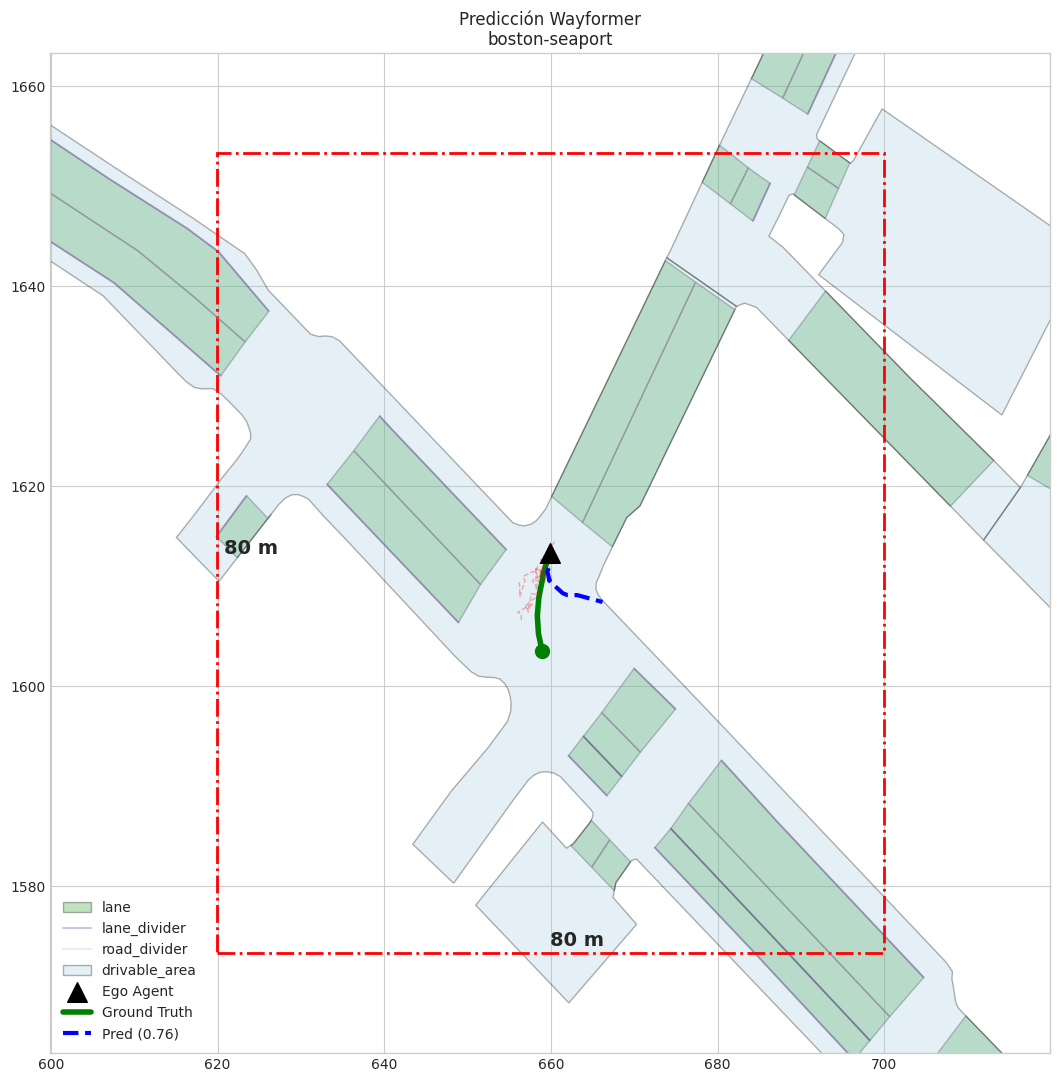


🎲 Visualizando índice aleatorio: 39



🎲 Visualizando índice aleatorio: 29


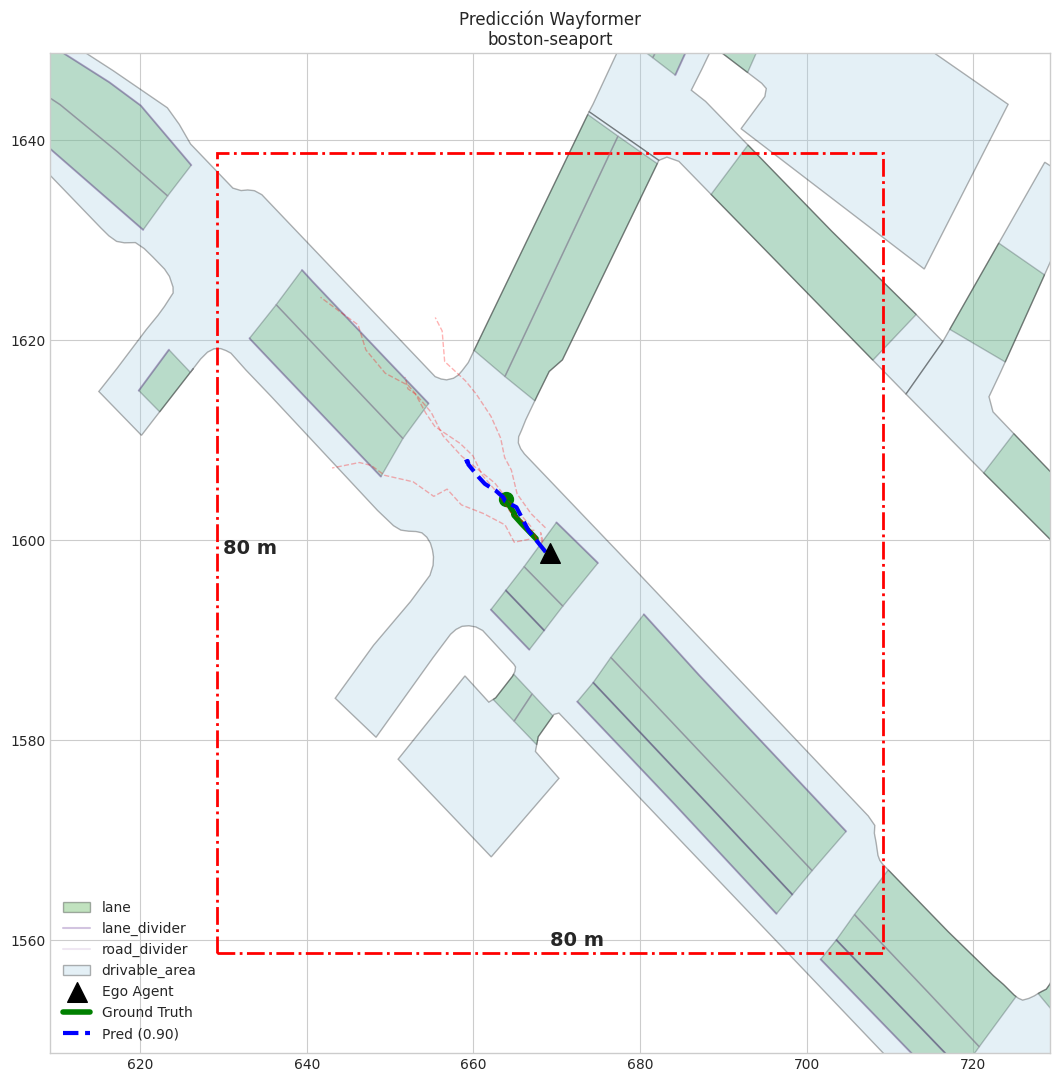

In [ ]:
import random

# Elegir 3 índices al azar
indices = random.sample(range(len(val_dataset)), 3)

for idx in indices:
    raw_token = val_dataset.token_list[idx]
    inst_tok, samp_tok = raw_token.split("_")
    
    print(f"\n🎲 Visualizando índice aleatorio: {idx}")
    visualize_sample(helper.data, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # 3. Transformar a Global (Predicciones y GT)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    # Predicciones Globales
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global)) # Shape: (12, 2)
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura (Renderizar Mapa estático)
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    # Renderizamos el mapa (esto crea la figura automáticamente)
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location} - {sample_token[:8]}")

    # 5. Inicializar objetos gráficos para la animación
    # Agente Ego (Triángulo fijo en el origen del movimiento)
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    
    # Puntos móviles
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    # Lista de líneas para los modos predichos
    pred_lines = []
    pred_heads = [] # Puntos en la cabeza de la trayectoria
    
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        # Línea de historia (traza)
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        # Punto actual (cabeza)
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Frame va de 0 a 11 (12 pasos)
        
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            # Traza completa hasta el frame actual
            current_x = traj[:frame+1, 0]
            current_y = traj[:frame+1, 1]
            
            pred_lines[i].set_data(current_x, current_y)
            
            # Cabeza en el frame actual
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # Crear animación
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() # Evitar que se muestre la figura estática duplicada
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Usamos el mismo sample que antes
idx_to_plot = 13
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# Generar y mostrar video
video_html = visualize_sample_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)
    
video_html

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from pyquaternion import Quaternion

def visualize_sample_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera una animación de video con la predicción.
    Devuelve el objeto 'anim' para poder guardarlo o visualizarlo.
    """
    # 1. Configuración de Mapa y Localización
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # 2. Preparar Datos (Inferencia)
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    
    # --- CORRECCIÓN 1: AÑADIR MÁSCARA ---
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    agent_mask = data['agent_mask'].unsqueeze(0).to(device) # <--- IMPORTANTE
    
    model.eval()
    with torch.no_grad():
        # Pasamos la máscara al modelo
        preds, logits = model(bev, agents, agent_mask=agent_mask)
    
    preds_local = preds[0].cpu().numpy()
    
    # Manejo seguro de logits si no existen
    if logits is not None:
        probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    else:
        probs = np.ones(len(preds_local)) / len(preds_local)
    
    # 3. Transformar a Global (Predicciones)
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))
    
    # Ground Truth Global
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    
    # 4. Configurar Figura
    my_patch = (origin_x - 40, origin_y - 40, origin_x + 40, origin_y + 40)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(8, 8)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Predicción Dinámica\n{location}")

    # 5. Inicializar objetos gráficos
    ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=5)
    gt_point, = ax.plot([], [], 'go', markersize=10, label='Ground Truth', zorder=6)
    
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    # Ordenar índices por probabilidad para pintar el mejor al final (encima)
    sorted_indices = np.argsort(probs)
    
    # Creamos las líneas en orden
    lines_dict = {} # Diccionario temporal para guardar referencias
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.2
        width = 2 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=5)
        
        pred_lines.append(line)
        pred_heads.append(head)

    ax.legend(loc='upper right')

    # 6. Función de Animación
    def update(frame):
        # Actualizar GT
        if len(future) > frame:
            gt_point.set_data([future[frame, 0]], [future[frame, 1]])
        
        # Actualizar Predicciones
        for i, traj in enumerate(all_preds_global):
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
                
        return [gt_point] + pred_lines + pred_heads

    # --- CORRECCIÓN 2: DEVOLVER OBJETO ANIM ---
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() 
    
    return anim

In [ ]:
# --- CONFIGURACIÓN ---
idx_to_plot = 13


# Ruta donde guardar
output_dir = "/root/nuscenes-devkit/python-sdk/main/results/videos/"
os.makedirs(output_dir, exist_ok=True) # Crear carpeta si no existe

name_video = f"prediction_video_model_1_idx_{idx_to_plot}.gif" 
ruta_completa = os.path.join(output_dir, name_video)

# Obtener tokens
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

print(f"🎬 Generando animación para sample {idx_to_plot}...")

# 1. Llamar a la función (Devuelve objeto anim)
# NOTA: Pasamos 'helper.data' como primer argumento, no el módulo 'nuscenes'
anim = visualize_sample_video(helper.data, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

if anim is not None:
    print(f"💾 Guardando video en: {ruta_completa}")
    
    # 2. Cambia el writer a 'pillow' (o quítalo, es el defecto para gif)
    anim.save(ruta_completa, writer='pillow', fps=5) 
    
    print("✅ Video guardado.")

    # 3. MOSTRAR EN NOTEBOOK (Opcional)
    display(HTML(anim.to_jshtml()))
else:
    print("❌ Error al generar la animación.")

🎬 Generando animación para sample 13...
💾 Guardando video en: /root/nuscenes-devkit/python-sdk/main/results/videos/prediction_video_model_1_idx_13.gif
✅ Video guardado.


In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_scene_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera un video con la predicción del agente objetivo Y el movimiento real de los vecinos.
    """
    # ---------------------------------------------------------
    # 1. Configuración del Mapa
    # ---------------------------------------------------------
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # ---------------------------------------------------------
    # 2. Inferencia del Agente Principal (Target)
    # ---------------------------------------------------------
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
    
    preds_local = preds[0].cpu().numpy()
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    
    # Transformar predicción a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))

    # Ground Truth del Target
    future_target = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

    # ---------------------------------------------------------
    # 3. Obtener Vecinos (Tráfico circundante)
    # ---------------------------------------------------------
    all_annotations = helper.get_annotations_for_sample(sample_token)
    neighbor_futures = []
    
    for neighbor in all_annotations:
        # Saltamos al agente principal (ya lo tenemos controlado)
        if neighbor['instance_token'] == instance_token:
            continue
            
        # Obtenemos el futuro de este vecino
        # Nota: Algunos pueden tener menos de 6 segundos de futuro si desaparecen
        fut = helper.get_future_for_agent(neighbor['instance_token'], sample_token, seconds=6, in_agent_frame=False)
        
        # Solo lo añadimos si tiene datos futuros
        if len(fut) > 0:
            neighbor_futures.append(fut)

    # ---------------------------------------------------------
    # 4. Configurar Figura
    # ---------------------------------------------------------
    # Centramos el mapa en el agente principal
    my_patch = (origin_x - 50, origin_y - 50, origin_x + 50, origin_y + 50)
    
    # Renderizar mapa estático
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area', 'ped_crossing'],
        alpha=0.4,
        figsize=(10, 10)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Escena Completa: Predicción (Azul) vs Tráfico Real (Naranja)\n{location}")

    # ---------------------------------------------------------
    # 5. Inicializar Objetos Gráficos
    # ---------------------------------------------------------
    
    # A. Target (Nuestro coche)
    start_point = ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=10)
    gt_point, = ax.plot([], [], 'go', markersize=8, label='Target GT', zorder=9)
    
    # B. Predicciones Target (Líneas)
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.1
        width = 3 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=4)
        pred_lines.append(line)
        pred_heads.append(head)

    # C. Vecinos (Nube de puntos naranja)
    # Usamos un solo objeto scatter para todos los vecinos por eficiencia
    neighbors_scatter = ax.scatter([], [], c='orange', s=60, edgecolors='k', label='Traffic', zorder=8)

    ax.legend(loc='upper right')

    # ---------------------------------------------------------
    # 6. Loop de Animación
    # ---------------------------------------------------------
    def update(frame):
        # frame: 0 a 11
        
        # 1. Actualizar Target GT
        if len(future_target) > frame:
            gt_point.set_data([future_target[frame, 0]], [future_target[frame, 1]])
            
        # 2. Actualizar Predicciones Target
        for i, traj in enumerate(all_preds_global):
            # Dibujar traza hasta el momento actual
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            # Dibujar cabeza
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
        
        # 3. Actualizar VECINOS
        current_neighbor_pos = []
        for fut in neighbor_futures:
            # Si este vecino todavía existe en este frame (tiempo t)
            if len(fut) > frame:
                current_neighbor_pos.append(fut[frame]) # [x, y]
        
        if len(current_neighbor_pos) > 0:
            neighbors_scatter.set_offsets(np.array(current_neighbor_pos))
        else:
            neighbors_scatter.set_offsets(np.empty((0, 2))) # Limpiar si no hay nadie
            
        return [gt_point, neighbors_scatter] + pred_lines + pred_heads

    # Generar
    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# Prueba con el mismo índice u otro interesante
idx_to_plot = 55
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

visualize_scene_video(nuscenes, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

# Analysis of the Transformer-Based Trajectory Prediction Model


## 1. What Works Well

### 1.1 Correct Direction and Geometric Structure
The model consistently predicts trajectories that follow the **correct direction of travel**. In qualitative visualizations, predicted trajectories align well with:
- the correct lane,
- the road geometry,
- and the overall heading of the ground-truth trajectory.

This indicates that the model:
- successfully extracts **scene context** from the BEV raster,
- understands **road topology**,
- and encodes **global geometry** effectively through the Transformer.

Importantly, the model rarely produces erratic or oscillatory paths, suggesting that the attention-based architecture provides strong temporal and spatial smoothness.

---

### 1.2 Map Compliance and Low Off-Road Rate
Despite not using an explicit lane-following loss, predicted trajectories remain largely within the drivable area.

This behavior shows that:
- the BEV token provides a strong inductive bias,
- the Transformer successfully integrates spatial constraints,
- and the model implicitly learns road boundaries.

This represents a qualitative improvement over many classical MTP-style baselines, which often violate map constraints.

---

### 1.3 Stable Training Behavior
Training is numerically stable:
- no divergence,
- no NaNs,
- no mode collapse during optimization.

Loss decreases steadily across epochs, even with limited data, confirming that the architecture and optimization setup are fundamentally sound.

---

## 2. What Goes Wrong

### 2.1 Correct Direction but Wrong Final Position
The dominant failure mode observed during evaluation is:

> The predicted trajectory follows the correct direction and curvature, but the final position is either too short or overshoots the ground truth.

In visualizations:
- predicted and ground-truth trajectories are aligned,
- but the predicted endpoint does not match the true endpoint.

---

### 2.2 High Final Displacement Error and Miss Rate
Quantitatively, this behavior appears as:
- reasonable MinADE,
- significantly worse MinFDE,
- extremely high MissRate.

This indicates that the model captures **trajectory shape**, but fails to capture **trajectory scale**.

---

## 3. Root Cause Diagnosis

### 3.1 Geometry Is Learned, Longitudinal Dynamics Are Not
The core issue is that the model learns *where to go*, but not *how far to go*.

Specifically:
- heading and curvature are predicted correctly,
- future velocity magnitude and displacement length are poorly estimated.

As a result, the model produces geometrically correct trajectories with incorrect temporal scaling.

---

### 3.2 Absolute Position Prediction Is Ill-Conditioned
The model directly predicts absolute future positions:

\[
(x_t, y_t)
\]

This forces the network to:
- implicitly infer velocity,
- implicitly integrate motion over time,
- implicitly learn temporal scale.

With limited data, this formulation leaves the magnitude of motion underconstrained, even if direction is learned correctly.

---

### 3.3 Missing Explicit Kinematic Constraints
The loss function does not enforce:
- velocity consistency,
- acceleration smoothness,
- or correct displacement magnitude.

Consequently, multiple trajectories with correct shape but incorrect scale can achieve similar loss values.

---

### 3.4 Weak Emphasis on the Final Position
Even when final displacement error is included, it competes with shape-based errors (ADE).

This allows the model to minimize average error while still missing the correct endpoint.

---

## 4. How the Diagnosis Was Confirmed

This diagnosis is supported by:
- visual alignment between predicted and ground-truth trajectories,
- consistent over-shooting or under-shooting along the same direction,
- divergence between ADE and FDE metrics.

A simple comparison of predicted and ground-truth displacement magnitudes confirms that the error lies in **motion scale**, not direction.

---

## 5. Summary

### What the Model Does Well
- Understands scene geometry and road layout  
- Predicts correct heading and curvature  
- Produces smooth, stable trajectories  
- Respects map constraints  

### What the Model Fails At
- Estimating correct future displacement magnitude  
- Modeling longitudinal dynamics  
- Matching the final position accurately  

### Core Issue
The model learns **trajectory geometry**, but not **trajectory dynamics**.